# CIS 667 - Fall 2016 Project

This notebook is used to demonstrate some examples of using a pre-trained convolutional neural network to produce new images based on what the neural net believes it sees in the input image.

[Caffe](http://caffe.berkeleyvision.org/) is the neural network framework that is used, and the code is adapted from the Google [DeepDream](https://github.com/google/deepdream) project. DeepDream uses the GoogleNet network model developed by Google, originally developed for the ImageNet Large-Scale Visual Recognition Challenge in 2014.

***

The DeepDream GoogleNet contains many layers as seen in this [graph](googlenet_deploy.jpeg) created by the Caffe `draw_net.py` script.

![DeepDream network](googlenet_deploy.jpeg)

***

The code in this notebook is licensed under the Apache License 2.0, which allows the use, modification and redistribution of the code. See [LICENSE](LICENSE) for details.

## Code

These functions are used throughout the notebook to process the various image files.

The `showarray` function is used to display the image inline in the notebook.
The `make_white_noise` function creates an image of the given size of random RGB levels, effectively producing a white noise image.

In [1]:
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

import random

# Paths to network model and weight data
model_path = 'models/bvlc_googlenet/'
net_fn = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Functions
def showarray(a, fmt='jpeg'):
    """Display an image defined in an array"""
    
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']

def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def make_white_noise_image(width, height):
    """Make a white noise image of the given width and height"""
    
    img = PIL.Image.new("RGBA", (width, height), 'white')
    noise_vals = map(lambda x: (
            int(random.random() * 256),
            int(random.random() * 256),
            int(random.random() * 256)
        ), [0] * width * height)
    img.putdata(noise_vals)
    
    return img

/home/tim/school/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/tim/school/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/tim/school/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


The model must be modified to allow for the gradients to be calculated required by the back-propagation step, which is not typically needed once the model is trained.

In [2]:
# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
proto_file = 'project_tmp.prototxt'

model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open(proto_file, 'w').write(str(model))

net = caffe.Classifier(proto_file, param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

The following functions are used to actually produce the images by performing the gradient ascent with a goal of maximizing certain activations of one of the layers in the network. In this example, taken from DeepDream, the L2-norm value is maximized during the back-propagation.

The target layer is specified as the `end` parameter of the `make_step` function.

In [3]:
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)
        
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

An image is chosen to start from. The original image of the Syracuse University quad is shown. 

This image is taken from the Syracuse University Financial Aid webpage at http://financialaid.syr.edu/whoareyou/internationalstudents/. Copyright © 2015. All Rights Reserved. Syracuse University

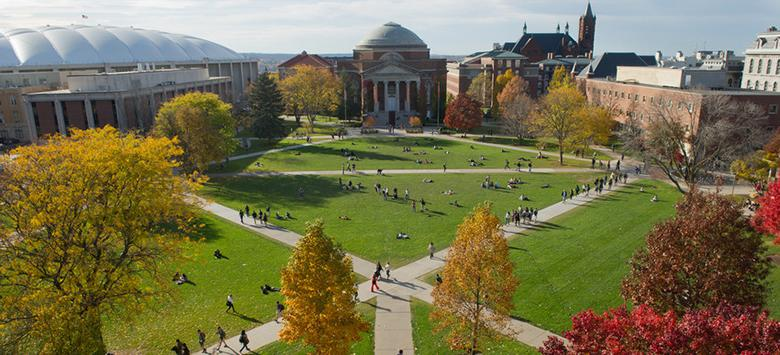

In [4]:
img = np.float32(PIL.Image.open('su_quad.jpg'))
showarray(img)

Next the image is run through the model. By default, the image is processed through four rounds of 10 steps each. The original image is first down-sampled. In each round, the down-sampled image is zoomed from the previous round. The steps within each round actually perform the gradient ascent and modify the input image to maximize the targeted layer.

When the example image is run, several features begin to appear in the modified image:

- The yellow trees are beginning to represent images of some types of animals, as legs, faces and ears begin to appear.
- To the right of Hendricks Chapel something that has the shape of a person, possibly with an eye appears.
- The Carrier Dome, Hendricks Chapel itself, and the sky have taken on a surreal texture.

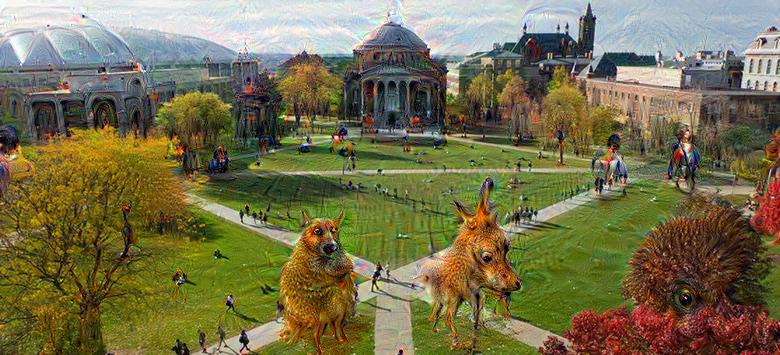

3 9 inception_4c/output (355, 780, 3)


In [5]:
out_img = deepdream(net, img)

In [6]:
PIL.Image.fromarray(np.uint8(out_img)).save("su_quad-inception_4c.jpg")

If the same image is used, but a different layer is targeted, the results are completely different. Here an earlier layer is selected. The features that begin to appear are less concrete, as the earlier layers of a convolutional neural network activate for more abstract features, such as edges or corners.

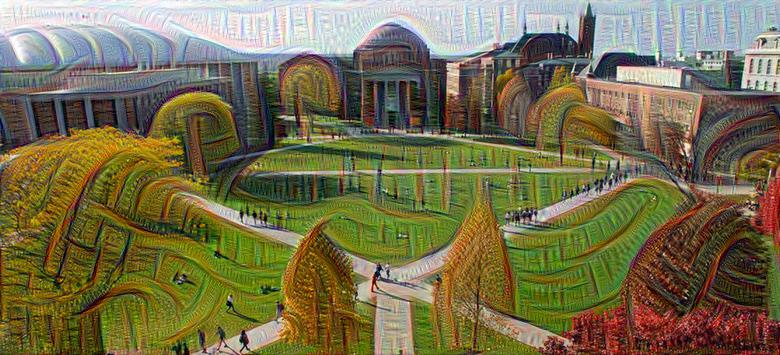

3 9 inception_3b/5x5_reduce (355, 780, 3)


In [7]:
_=deepdream(net, img, end='inception_3b/5x5_reduce')

Again, if the process is done on the same image with a higher layer, features that are more concrete become prominent.

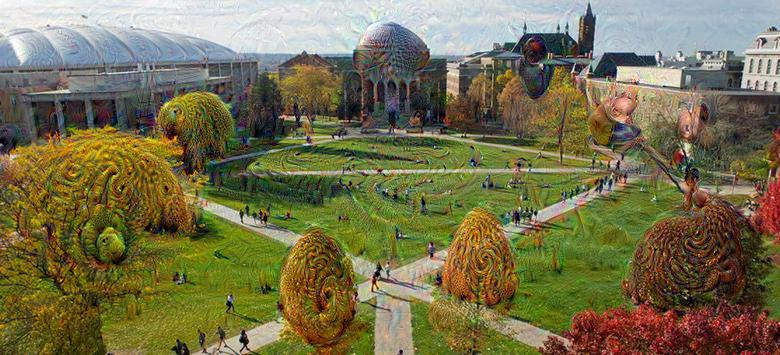

3 9 inception_5a/output (355, 780, 3)


In [8]:
_=deepdream(net, img, end='inception_5a/output')

Finally, the image is run through the algorithm 100 times and the results produced are quite something.

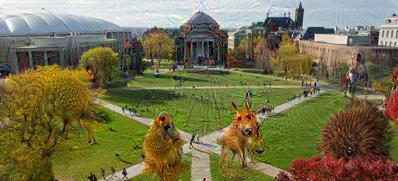

1 9 inception_4c/output (181, 398, 3)


In [ ]:
import datetime
import os

# Make unique output directory for images
out_dir = 'su_quad-{:%Y%m%dT%H%M%S}'.format(datetime.datetime.now())
os.makedirs(out_dir)

frame = img
frame_i = 0

h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(100):
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("{}/{:04d}.jpg".format(out_dir, frame_i))
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

Next, a white noise image is generated and then shown being input into the network, again targeting several different layers in the network. This demonstrates that the network even attempts to recognize and classify things when presented with a completely random image.

In [ ]:
img = np.float32(PIL.Image.open('su_quad.jpg'))
# noise_img = make_white_noise_image(224, 224)
noise_img = np.float32(PIL.Image.open('white_noise.jpeg'))
showarray(noise_img)
# noise_img.save('white_noise.jpeg')

# Save image to memory file
f = StringIO()
noise_img.save(f, 'jpeg')

In [ ]:
_=deepdream(net, np.float32(PIL.Image.open(f)), octave_n=4, iter_n=10, end='inception_5a/output')

In [ ]:
_=deepdream(net, np.float32(PIL.Image.open(f)), octave_n=4, iter_n=10, end='inception_3a/output')

In [ ]:
_=deepdream(net, np.float32(PIL.Image.open(f)), octave_n=4, iter_n=10)